In [0]:
import requests

res = requests.get('https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt')

f = open('train.txt',"wb")
f.write(res.content)
f.close()

In [0]:
import re
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

In [0]:
f = open('train.txt', 'r')
tagged_sentences = []
sentence = []

for line in f:
  if len(line) == 0 or line.startswith('-DOCSTART') or line[0]=="\n":
    if len(sentence) > 0:
      tagged_sentences.append(sentence)
      sentence = []
    continue
  splits = line.split(' ')
  splits[-1] = re.sub(r'\n','',splits[-1])
  word = splits[0].lower()
  sentence.append([word,splits[-1]])

In [14]:
print("전체 샘플 개수: ", len(tagged_sentences))

전체 샘플 개수:  14041


In [15]:
print(tagged_sentences[0])

[['eu', 'B-ORG'], ['rejects', 'O'], ['german', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['british', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]


In [0]:
sentences, ner_tags = [], []

for tagged_sentence in tagged_sentences:
  sentence, tag_info = zip(*tagged_sentence)
  sentences.append(list(sentence))
  ner_tags.append(list(tag_info))

In [19]:
print(sentences[0])
print(ner_tags[0])

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


In [20]:
print(sentences[12])
print(ner_tags[12])

['only', 'france', 'and', 'britain', 'backed', 'fischler', "'s", 'proposal', '.']
['O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-PER', 'O', 'O', 'O']


샘플의 최대 길이 : 113
샘플의 평균 길이 : 14.501887


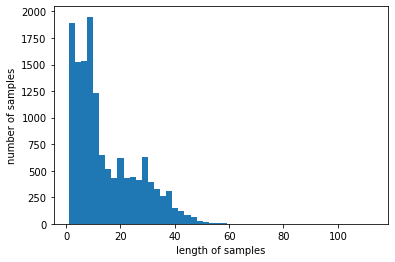

In [21]:
print('샘플의 최대 길이 : %d'%max(len(i) for i in sentences))
print('샘플의 평균 길이 : %f'%(sum(map(len,sentences))/len(sentences)))
plt.hist([len(i) for i in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [0]:
max_words = 4000
src_tokenizer = Tokenizer(num_words=max_words, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

In [23]:
vocab_size = max_words
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 4000
개체명 태깅 정보 집합의 크기 : 10


In [0]:
x_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

In [25]:
print(x_train[0])
print(y_train[0])

[989, 1, 205, 629, 7, 3939, 216, 1, 3]
[4, 1, 7, 1, 1, 1, 7, 1, 1]


In [0]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

In [27]:
decoded = []
for index in x_train[0]:
  decoded.append(index_to_word[index])

print('기존문장 : {}'.format(sentences[0]))
print('빈도수가 낮은 단어가 OOV 처리된 문장 : {}'.format(decoded))

기존문장 : ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
빈도수가 낮은 단어가 OOV 처리된 문장 : ['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']


In [0]:
max_len = 70
x_train = pad_sequences(x_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=.2, random_state=777)

In [0]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [31]:
print('훈련 샘플 문장의 크기 : {}'.format(x_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(x_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (11232, 70)
훈련 샘플 레이블의 크기 : (11232, 70, 10)
테스트 샘플 문장의 크기 : (2809, 70)
테스트 샘플 레이블의 크기 : (2809, 70, 10)


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from keras.optimizers import Adam

In [0]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

In [34]:
model.compile(loss = 'categorical_crossentropy', optimizer=Adam(0.001), metrics=['acc'])
model.fit(x_train,y_train, batch_size=128, epochs=8, validation_data=(x_test, y_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 11232 samples, validate on 2809 samples
Epoch 1/8
11232/11232 [==============================] - 133s 12ms/step - loss: 0.1853 - acc: 0.8226 - val_loss: 0.1281 - val_acc: 0.8315
Epoch 2/8
11232/11232 [==============================] - 132s 12ms/step - loss: 0.0974 - acc: 0.8574 - val_loss: 0.0752 - val_acc: 0.8843
Epoch 3/8
11232/11232 [==============================] - 132s 12ms/step - loss: 0.0635 - acc: 0.9093 - val_loss: 0.0511 - val_acc: 0.9276
Epoch 4/8
11232/11232 [==============================] - 132s 12ms/step - loss: 0.0441 - acc: 0.9391 - val_loss: 0.0400 - val_acc: 0.9443
Epoch 5/8
11232/11232 [==============================] - 133s 12ms/step - loss: 0.0340 - acc: 0.9520 - val_loss: 0.0353 - val_acc: 0.9514
Epoch 6/8
11232/11232 [==============================] - 132s 12ms/step - loss: 0.0288 - acc: 0.9586 - val_loss: 0.0333 - val_acc: 0.9541
Epoch 7/8
11232/11232 [==============================] - 132s 12ms/step - loss: 0.0245 - acc: 0.9649 - val_loss: 0.0316 - v

In [36]:
i=10
y_predicted = model.predict(np.array([x_test[i]]))
y_predicted = np.argmax(y_predicted, axis=-1)
true = np.argmax(y_test[i], -1)

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(x_test[i], true, y_predicted[0]):
  if w != 0:
    print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t].upper(), index_to_ner[pred].upper()))

단어             |실제값  |예측값
-----------------------------------
sarah            : B-PER   B-PER
brady            : I-PER   I-PER
,                : O       O
whose            : O       O
republican       : B-MISC  B-MISC
husband          : O       O
was              : O       O
OOV              : O       O
OOV              : O       O
in               : O       O
an               : O       O
OOV              : O       O
attempt          : O       O
on               : O       O
president        : O       O
ronald           : B-PER   B-PER
reagan           : I-PER   I-PER
,                : O       O
took             : O       O
centre           : O       O
stage            : O       O
at               : O       O
the              : O       O
democratic       : B-MISC  B-MISC
national         : I-MISC  I-MISC
convention       : I-MISC  I-MISC
on               : O       O
monday           : O       O
night            : O       O
to               : O       O
OOV              : O       O
pre